# Camera calibration
    Use provided calibration images to find corner points, calibrate and remove distortion effects

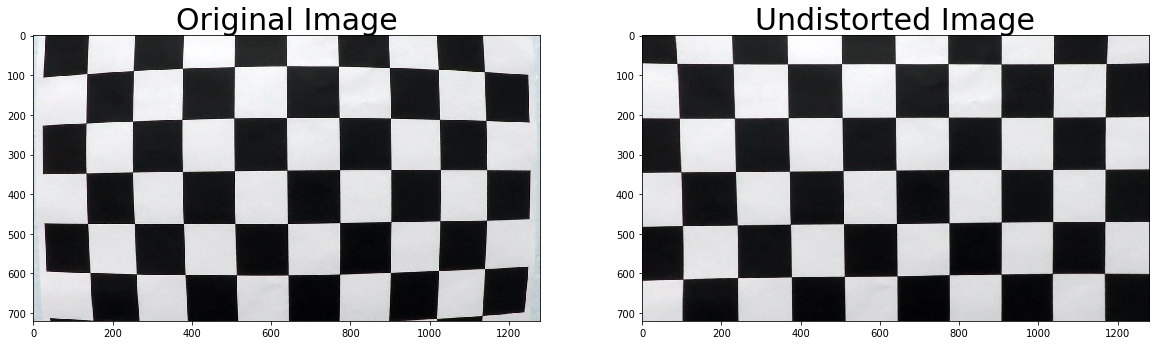

In [1]:
#find corner points in calibration images using CV2 as in lesson
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os

#set chessboard size for calib images
nx = 9
ny = 6
imagepointlist = []
objectpointlist = []

#load all calibration images
cwd = os.getcwd()
images = glob.glob(cwd+ '/camera_cal/calibration*.jpg')

#array with x,y,z coords for one image
objectpoints = np.zeros((ny*nx,3), np.float32)
objectpoints[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
for fname in images:
    img = mpimg.imread(fname)
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, append both sets of coordinates to lists
    if ret == True:
        imagepointlist.append(corners)
        objectpointlist.append(objectpoints)
        
#Calibrate and undistort 
img = cv2.imread(cwd+ '/camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

#calibrate with object and imagepoints
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objectpointlist, imagepointlist, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('examples/test_undist.jpg',dst)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
plt.savefig('examples/undist_before_after.jpg')


# Correct for image distortion
    Load sample pictures and correct distortion

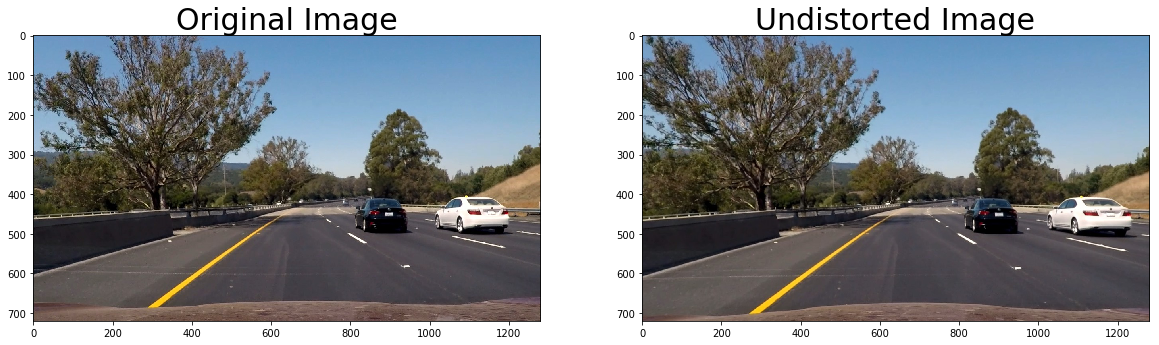

In [2]:
#load test pictures and apply undistortion
timages = glob.glob('test_images/*')

def undist(img):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst
timages_undist = []
for t in timages:
    timg = mpimg.imread(t)
    tundist = undist(timg)
    timages_undist.append(tundist)
    if 'test6.jpg' in t:
        # show original and undistorted, save to file
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.imshow(timg)
        ax1.set_title('Original Image', fontsize=30)
        ax2.imshow(tundist)
        ax2.set_title('Undistorted Image', fontsize=30)
        plt.savefig('examples/undist_before_after2.jpg')


# Color/gradient thresholding
    Apply thesholding for easier lane identification

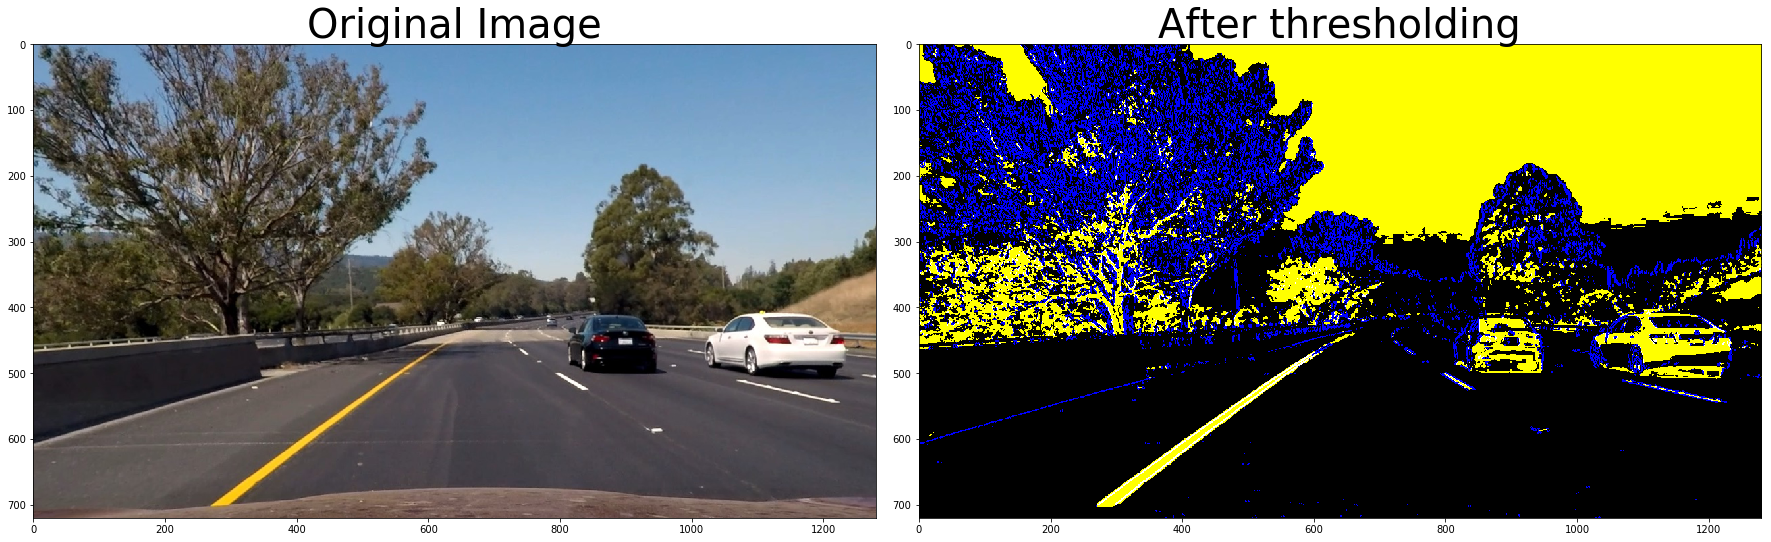

In [3]:
#combination of color and gradient thesholding as suggested in lessons

def combined_thes(img, s_thresh=(90, 255),h_thresh=(15, 100), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1])] = 1

    # Stack each channel
    #best result by merging sobelx and s channel
    color_binary = np.dstack((s_binary,s_binary, sxbinary)) * 255
    
    return color_binary

   
    
    
timages_thres = []
for i in timages_undist:
    img_thres = combined_thes(i)
    timages_thres.append(img_thres)


# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(timages_undist[-1])
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(timages_thres[-1], cmap='gray')
ax2.set_title('After thresholding', fontsize=40 )
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('examples/threshold_before_after.jpg')


# Perspective transform
Get a top-down view of the lane lines

In [ ]:
#appyl perspective transform

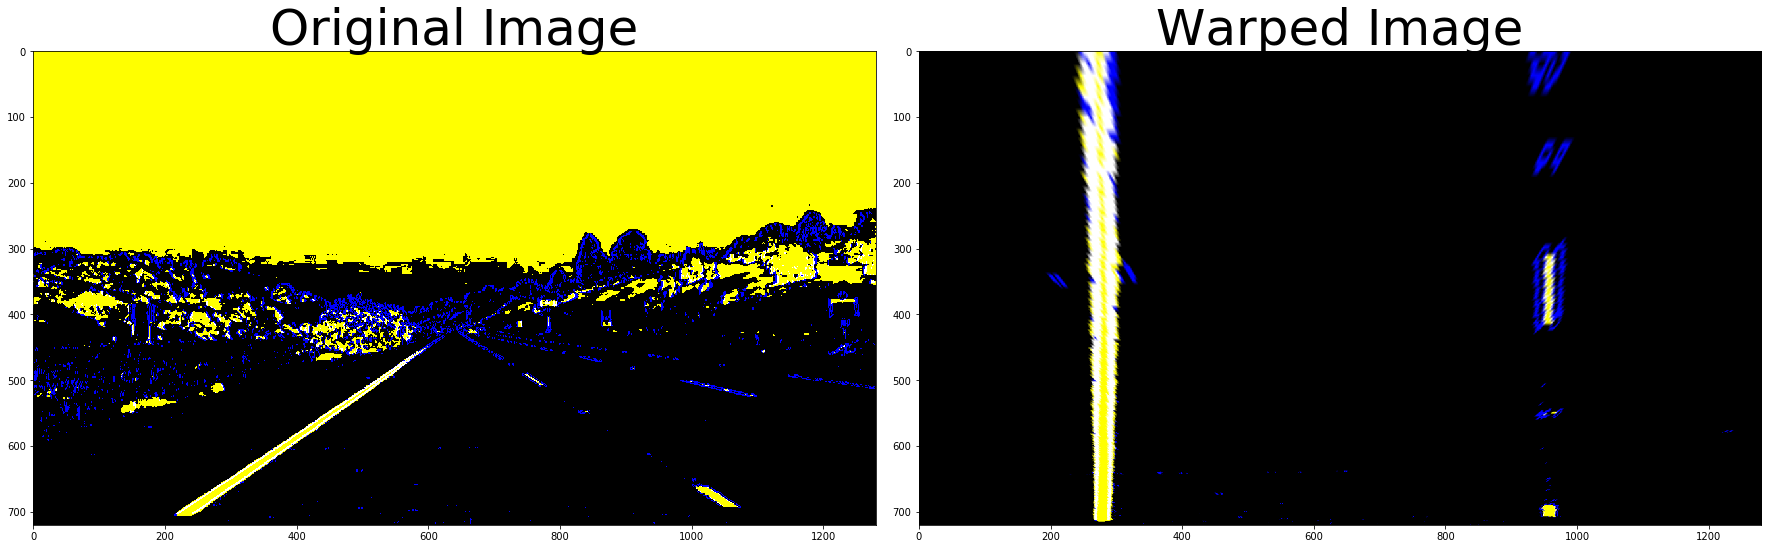

In [4]:
def persp_transform(img):
    img_size = (img.shape[1], img.shape[0])
    #source and destination points eye-balled from first test picture
    offset = 100
    src = np.float32([[707,465], [1095, 720] ,[208,720],[576, 465] ])
    dst = np.float32([[950,0], [950, 720] ,[280, 720],[280, 0] ])
    a1 = [offset, offset] #upper left
    b1 = [img_size[0]-offset, offset] #upper right
    c1 = [img_size[0]-offset, img_size[1]-offset] # lower right
    d1 = [offset, img_size[1]-offset] # lower left
    #dst = np.float32([b1,c1,d1,a1])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    img_topd = cv2.warpPerspective(img, M, img_size)
   
    return M, Minv, img_topd

timages_td = []
for img in timages_thres:
#for img in timages_undist:
    M, Minv, img_topd = persp_transform(img)
    timages_td.append(img_topd)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(timages_thres[0])
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(timages_td[0])
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('examples/warp_before_after.jpg')


# Find and fit lanes
Identify lane line pixels and fit polynomial for curves

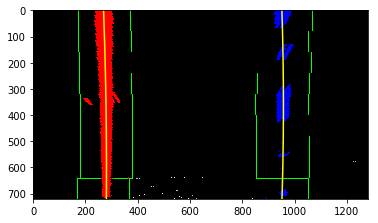

In [5]:
#using sliding window method from lesson
binary_warped = cv2.cvtColor(timages_td[0], cv2.COLOR_BGR2GRAY)


histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)


# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.savefig('examples/lane_fitting.jpg')


In [6]:
#shorter search

# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
left_fit[1]*nonzeroy + left_fit[2] + margin))) 

right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Curvature
Get curvature in pixels and meters

In [7]:

#eftx = leftx[::-1]  # Reverse to match top-to-bottom in y
#ightx = rightx[::-1]  # Reverse to match top-to-bottom in y

#get curvature from polynomial
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image

# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48


16493.2874839 11432.1956888


In [8]:
#curvature in m
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m


5416.92148186 m 3749.59884844 m


# Display results 
Show the lane marked on the undistorted test image

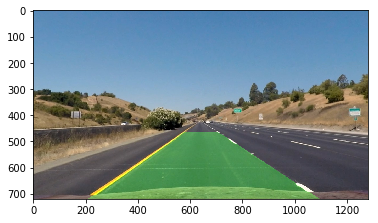

In [9]:
#draw result
# Create an image to draw the lines on
warped = cv2.cvtColor(timages_td[0], cv2.COLOR_BGR2GRAY)

warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (timages_td[0].shape[1], timages_td[0].shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(timages_undist[0], 1, newwarp, 0.3, 0)
plt.imshow(result)
plt.savefig('examples/result.jpg')
